In [1]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
pfcn_small = np.load(r'/Users/sunhyeoklee/Desktop/AdvanceProject/pfcn_small.npz')

In [3]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

In [4]:
train_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images]
)
test_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images]
)

In [5]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [6]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100.0, 255.0, 255.0]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100.0, 255.0, 255.0]

print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 1.0
0.19397112017382204 0.8400303209378145
0.14128202093029715 0.8698299619820618


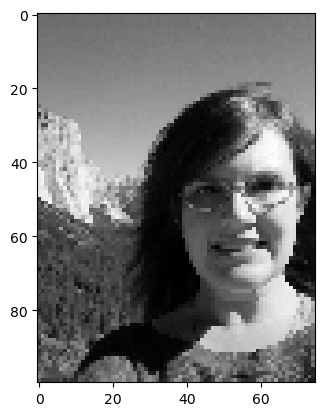

In [7]:
plt.imshow(train_lab_images[0][..., 0], cmap="gray")
plt.show()

In [9]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [10]:
inputs = Input((100, 75, 1))

c1 = conv2d_block(inputs, 16)
p1 = MaxPool2D(2)(c1)
p1 = Dropout(0.1)(p1)

c2 = conv2d_block(p1, 32)
p2 = MaxPool2D(2)(c2)
p2 = Dropout(0.1)(p2)

c3 = conv2d_block(p2, 64)
p3 = MaxPool2D(2)(c3)
p3 = Dropout(0.1)(p3)

c4 = conv2d_block(p3, 128)
p4 = MaxPool2D(2)(c4)
p4 = Dropout(0.1)(p4)

c5 = conv2d_block(p4, 256)

u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0, 1))(c5)
u6 = concatenate([u6, c4])
u6 = Dropout(0.1)(u6)
c6 = conv2d_block(u6, 128)

u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1, 0))(c6)
u7 = concatenate([u7, c3])
u7 = Dropout(0.1)(u7)
c7 = conv2d_block(u7, 64)

u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0, 1))(c7)
u8 = concatenate([u8, c2])
u8 = Dropout(0.1)(u8)
c8 = conv2d_block(u8, 32)

u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c8)
u9 = concatenate([u9, c1])
u9 = Dropout(0.1)(u9)
c9 = conv2d_block(u9, 16)

outputs = Conv2D(2, 1, activation="sigmoid")(c9)
unet_model = Model(inputs, outputs)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 75, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 75, 16)  160         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 75, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
unet_model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

In [ ]:
hist = unet_model.fit(
    train_lab_images[..., 0],
    train_lab_images[..., 1:],
    validation_data=(test_lab_images[..., 0], test_lab_images[..., 1:]),
    epochs=500,
    verbose=1,
    callbacks=[checkpoint_callback],
)

Epoch 1/500


2025-10-31 09:12:47.930900: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


54/54 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.5655
Epoch 1: val_accuracy improved from -inf to 0.59052, saving model to best_model.keras
54/54 [==============================] - 10s 82ms/step - loss: 0.0075 - accuracy: 0.5655 - val_loss: 0.0028 - val_accuracy: 0.5905
Epoch 2/500
53/54 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.5924
Epoch 2: val_accuracy improved from 0.59052 to 0.62404, saving model to best_model.keras
54/54 [==============================] - 2s 32ms/step - loss: 0.0030 - accuracy: 0.5927 - val_loss: 0.0027 - val_accuracy: 0.6240
Epoch 3/500
53/54 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.5949
Epoch 3: val_accuracy did not improve from 0.62404
54/54 [==============================] - 2s 30ms/step - loss: 0.0028 - accuracy: 0.5948 - val_loss: 0.0027 - val_accuracy: 0.5966
Epoch 4/500
53/54 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.6021
Epoch 4: val_ac

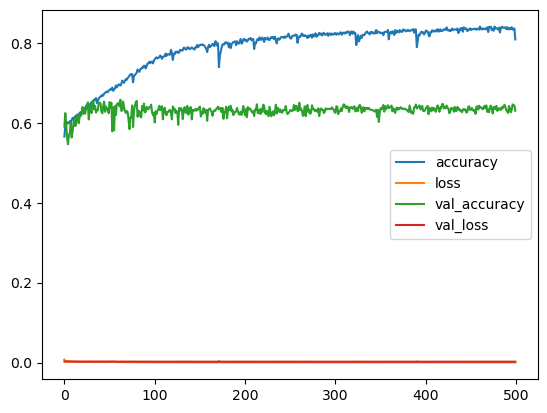

In [18]:
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend(loc="right")
plt.show()

In [40]:
list(hist.history.keys())

['loss', 'accuracy', 'val_loss', 'val_accuracy']

In [43]:
max(hist.history["accuracy"])

0.8408021926879883

In [44]:
max(hist.history["val_accuracy"])

0.6575213074684143

In [45]:
min(hist.history["loss"])

0.00026423513190820813

In [46]:
min(hist.history["val_loss"])

0.0021271351724863052

In [ ]:
def predict_and_lab2rgb(lab_image):
    pred_ab = unet_model.predict(np.expand_dims(lab_image, (0, -1)))  # 차원을 추가
    pred_img = np.zeros((100, 75, 3))

    pred_img[:, :, 0] = lab_image.reshape((100, 75))
    pred_img[:, :, 1:] = pred_ab[0]

    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img

In [ ]:
predict_rgbImages = np.array([predict_and_lab2rgb(a_test_lab_image[..., 0]) for a_test_lab_image in test_lab_images[:5]])

1/1 [==============================] - 0s 12ms/step


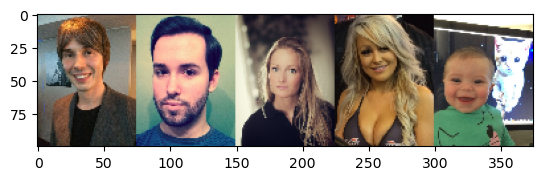

In [27]:
plt.imshow(test_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3)), cmap="viridis")
plt.show()

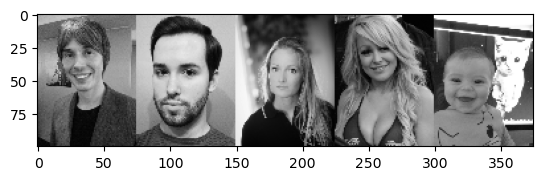

In [25]:
# test_lab_images.shape
plt.imshow(test_lab_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3))[..., 0], cmap="gray")
plt.show()

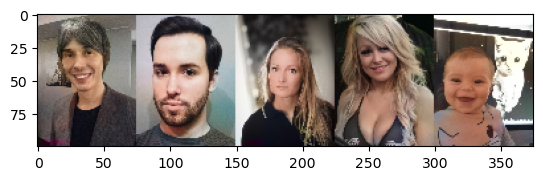

In [ ]:
plt.imshow(predict_rgbImages[:].transpose((1, 0, 2, 3)).reshape((100, -1, 3)), cmap="viridis")
plt.show()

In [20]:
unet_model.save("colorization_model_1031.keras")

In [21]:
unet_model.save_weights("colorization_model_1031_weights.h5")